# Libreta Clase de Deep Reinforcement Learning
*Por Roberto-Esteban López-Díaz*

## Objetivos de esta libreta
- Crear Entornos
- Desde la estructura del MDP, definir un entorno GridWorld

In [ ]:
### EJECUTAR SOLO UNA VEZ ###
!pip install gif
!git clone https://github.com/Bobobert/RL_Toy
!pip install /content/RL_Toy/

In [ ]:
### EJECUTAR SOLO UNA VEZ ###
### SOLO NECESARIA EN COLAB ###
# Colab virtualDisplay for gym Environments
# This may not be necesary outside google colab
!sudo apt update
!apt install python-opengl
!apt install ffmpeg
!sudo apt-get install xvfb
!pip3 install pyvirtualdisplay

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1280, 720))
virtual_display.start()

In [1]:
from abc import ABC
from gym import make

import numpy as np
import matplotlib.pyplot as plt

## Clases Abstractas para un Espacio de acciones y observaciones

Se definen dos clases base para definir de alguna manera el espacio de acciones y observaciones para usar en un entorno personalizado.



In [6]:
class ActionSpace(ABC):
    """
    Discrete Action Space class.
    Stores all the posible actions for an environment and can generate
    samples with the method sample().

    Parameters
    ----------
    n: int
        Number of total actions. These are consider to be sequential.
    minValue: int
        Default 0. The minimum value that the action can take. It's
        the lower inclusive of the action space intervals 
        [minValue, minValue + n)
    """
    def __init__(self, n:int, minValue:int=0):
        assert n > 0, "Number of actions must be greater than 0"
        self.n = n
        self.mV = minValue
    
    @property
    def shape(self):
        return self.n

    def __iter__(self):
        self.actions = []
        self.i = 0
        for i in range(self.n):
            self.actions += [self.mV + i]
        return self
    
    def __next__(self):
        if self.i == self.n:
            raise StopIteration
        nx = self.actions[self.i]
        self.i += 1
        return nx

    def sample(self):
        """
        Returns a random sample with an uniform distribution of the
        actions.
        """
        return np.random.randint(self.mV, self.mV + self.n)

class ObservationSpace(ABC):
    """
    Discrete observation space class

    Stores all the posible observations for an environment and can generate
    samples with the method sample().

    Parameters
    ----------
    n: int
        Number of total variation that cell can occupy. 
        These are consider to be sequential.
    shape : tuple
        Shape of the state compose of cell's states.
    minValue: int
        Default 0. The minimum value that a cell's state can take. It's
        the lower inclusive of the action space intervals 
        [minValue, minValue + n)
    """
    def __init__(self, n:int, shape:tuple, minValue:int = 0):
        assert n > 0, "Number of cell states must be greater than 0"
        self._state_ = np.zeros(shape, dtype=np.int)
        self._n_ = n
        self.mV = minValue

    @property
    def shape(self):
        return self._state_.shape

    def sample(self):
        """
        Returns a random sample with an uniform distribution of the
        cell's states.
        """
        return np.random.randint(self.mV, self.mV + self._n_, size = self.shape)


In [7]:
class Environment(ABC):
    """
    Environment base class.
    """
    def step(self, action):
        """
        Executes the action, updates the environment, calculates 
        the reward and observation output.
        Returns
        -------
        observation, reward, done
        """
        raise NotImplemented
    def reset(self):
        """
        Restart the initial state of the environment, 
        in a deterministic or stochastic manner
        Returns
        ------
        obeservation
        """
        raise NotImplemented
    def getObservation(self):
        """
        Calculates and returns the observation of 
        the actual state of the environment.
        """
        raise NotImplemented
    def calculateReward(self, state):
        """
        Calculate with the actual mode the reward 
        from the last observation made in the environment

        Returns
        -------
        reward
        """
        raise NotImplemented
    @property
    def actionSpace(self):
        """
        Returns the ActionShape class designed of the environment.
        """
        raise NotImplemented
    @property
    def observationSpace(self):
        """
        Returns a list or generator of all the states availables. 
        """
        raise NotImplemented
    def transProb(self, state, action):
        """
        Returns the probabilities and states of the transitions from the
        state and action given.
        """
        raise NotImplemented
    def isTerminal(self, state):
        """
        Returns the bool that expreses if 
        the actual state is a terminal one
        or not.
        """
        raise NotImplemented

### Diseñando un entorno - GridWorld

Un **GridWorld** o "mundo retícula", es un caso básico a analizar y encontrarle analogos a un entorno real podria resultar sencillo. Aunque se describa como un caso sencillo, nos permite observar fenomenos interesantes en el contexto de aprendizaje por refuerzo.

Preguntas interesantes acerca de este entorno serían:
- ¿Que representación del estado seria suficiente?
- De crecer una columna o fila al entorno, ¿incrementa mucha nuestra complejidad computacional?
- ¿Qué utilidad podría tener un modelo así?

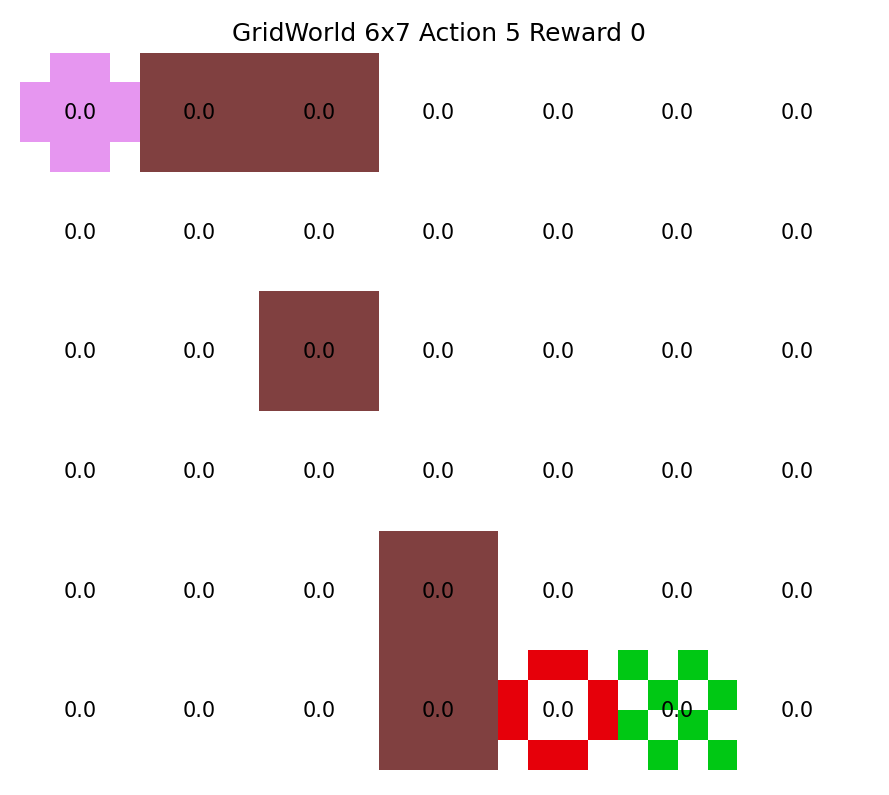

In [67]:
class gridWorld(Environment):
    """
    Little and simple environment for a deterministic grid world.
    Parameters
    ----------
    width: int
        First dimension of the grid
    height: int
        Second dimension of the grid
    initPos: tuple of int
        Initial position of the agent.
    goal: tuple of int
        Position of the first goal to create the grid.
        One can add more goals later if required.
    movement: str
        Default 8C. Refer to step method.
    horizon: int
        Default 10**6. Number of steps to run the environment before it
        terminates.
    """
    # All gfx related
    EMPTYC = (255, 255, 255)
    OBST = 2
    OBSTC = (128, 64, 64)
    VORTEX = 3
    VORTEXC = (230, 0, 10)
    GOAL = 1
    GOALC = (0, 200, 20)
    AGENTC = (230, 150, 240)
    POLICYC = (0, 1, 0.5)
    CELLSIZE = 4
    GRAPHSCALE = 1.2    

    VORTEXD = [[False, True, True, False],
             [True, False, False, True],
             [True, False, False, True],
             [False, True, True, False]]

    AGENTD = [[False, True, True, False],
              [True, True, True, True],
              [True, True, True, True],
              [False, True, True, False]]

    GOALD = [[True, False, True, False],
             [False, True, False, True],
             [True, False, True, False],
             [False, True, False, True]]

    # Action meaning related
    actions  = [(-1,-1),(-1, 0),(-1,1),
              (0, -1),(0, 0),(0, 1),
              (1, -1),(1, 0),(1, 1)]

    actions4C = [1,3,4,5,7]

    def __init__(self, width:int, height:int, initPos:tuple, 
                 goal:tuple, movement:str = "4C", horizon:int = 10**6):
        # Grid Related
        self.grid = np.zeros((width, height), dtype=np.uint8)
        self._w = width
        self._h = height
        self.obstacles = []
        self.vortex = []
        self.goal = [goal]
        self.steps = 0
        self.gameOver = False
        self.horizon = horizon
        # Agent related
        self.movMode = movement
        self.validateTuple(initPos)
        self.initX, self.initY = initPos
        self.posX, self.posY = initPos
        self.__actionSpace = ActionSpace(9 if movement == "8C" else 5, 1)
        self.__obsSpace = ObservationSpace(4, self.grid.shape)
        # Graphics related
        self.frame = np.zeros((width * self.CELLSIZE, height * self.CELLSIZE, 3), 
                              dtype=np.uint8)
        # Initialize the grid
        self.reset()

    def validateTuple(self, T:tuple):
        assert len(T) == 2, "Tuple needs to have 2 items for x and y"
        if (T[0] < 0) or (T[1] < 0):
            raise ValueError("Values of the tuple must be non-negative")
        if (T[0] >= self._w) or (T[1] >= self._h):
            raise ValueError("Value of the tuple need to be in the \
                    interval x[0, {}), y[0, {})".format(self._w, self._h))
        return True
    
    def addVortex(self, *vortex):
        """
        Add a vortex on the grid
        Parameters
        ---------
        vortex: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put a new vortex.
        """
        for v in vortex:
            self.validateTuple(v)
            self.vortex += [v]

    def addObstacles(self, *obstacles):
        """
        Add an obstacle on the grid
        Parameters
        ---------
        obstacles: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put a new obstacle.
        """
        for o in obstacles:
            self.validateTuple(o)
            self.obstacles += [o]
    
    def addGoals(self, *goals):
        """
        Add a goal on the grid
        Parameters
        ---------
        goal: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put an additional goal.
        """
        for g in goals:
            self.validateTuple(g)
            self.goal += [g]

    def reset(self, initialPos = None):
        self.grid[:,:] = 0
        for o in self.obstacles:
            self.grid[o] = self.OBST
        for v in self.vortex:
            self.grid[v] = self.VORTEX
        for g in self.goal:
            self.grid[g] = self.GOAL
        if initialPos is None:
            self.posX = self.initX
            self.posY = self.initY
        else:
            self.validateTuple(initialPos)
            self.posX, self.posY = initialPos
        self.steps = 0
        self.gameOver = False
        self.lastObs = self.getObservation()
        self.lastReward = 0
        self.lastAction = 5
        return self.lastObs

    def step(self, action:int = 5):
        """
        Excecute a step on the environment. 
        The actions on the grid that the agent can take on mode 8C are
        integers from 1 to 9.

            [1  2  3]
            |4  5  6|
            [7  8  9]

        5 being the neutral action or "Do nothing"

        In mode 4C, the action space is reduced to just move in a cross 
        pattern with integers from 1 to 5

            [-  1  -]
            |2  3  4|
            [-  5  -]
        
        3 being the "do nothing" action.

        Parameters
        ----------
        action: int
            
        Returns
        -------
        observation , reward, done
        """
        # If the environment has reached a terminal state
        if self.gameOver:
            return self.lastObs, 0, True
        # Select the action from the corresponding transition probabilities
        randomSelect = np.random.uniform(0,1)
        probs, states = self.transProb(self.lastObs, action)
        lastP = 0
        for p, s in zip(probs, states):
            if randomSelect <= (p + lastP):
                self.posX, self.posY = s
                break
            else:
                lastP += p
        self.steps += 1
        # Check the horizon
        if self.steps > self.horizon:
            self.gameOver = True
        # Get new state and reward
        self.lastObs = self.getObservation(copy = False)
        self.lastReward = self.calculateReward(self.lastObs)
        return self.lastObs, self.lastReward, self.isTerminal(self.lastObs)

    def validateAction(self, state, action:int):
        if self.movMode == "8C":
            assert (action > 0) and (action < 10), \
            "Action must be an integer between 1 and 9"
            dx, dy = self.actions[action - 1]
        elif self.movMode == "4C":
            assert (action > 0) and (action < 6), \
                "Action must be an integer between 1 and 5"
            dx, dy = self.actions[self.actions4C[action - 1]]
        self.lastAction = action
        posX, posY = state["agent"]
        # Tentative new position
        posX += dx
        posY += dy
        # Checking the movements be inside the grid
        if (posX < 0) or (posX >= self._w) or (posY < 0) or (posY >= self._h):
            # Is not inside the grid, this does nothing
            return state["agent"]
        # Checking if the movement gets it to an obstacle
        elif self.grid[posX, posY] == self.OBST:
            # Returns the same position as before
            return state["agent"]
        else:
            # No obstacle the new position is returned
            return posX, posY
    
    def calculateReward(self, state):
        grid = state["grid"]
        pos = state["agent"]
        reward = 0

        reward += -1
        reward += pos[0]*pos[1]

        return reward


    def getObservation(self, copy:bool = True):
        return {"grid":self.grid, "agent":(self.posX,self.posY)}

    def render(self, values=None, policy=None):
        # Suboptimal but simple to understand graphics for the environment
        fig = plt.figure(
            figsize=(self._w * self.GRAPHSCALE, self._h * self.GRAPHSCALE), 
            clear = True)
        self.frame[:,:] = self.EMPTYC
        for i in range(self._w):
            for j in range(self._h):
                cell = self.grid[i,j]
                ni, nj = self.CELLSIZE * i, self.CELLSIZE * j
                f = self.frame[ni:ni+self.CELLSIZE,nj:nj+self.CELLSIZE]
                if cell == self.OBST:
                    f[:,:,:] = self.OBSTC
                elif cell == self.VORTEX:
                    f[self.VORTEXD,:] = self.VORTEXC
                elif cell == self.GOAL:
                    f[self.GOALD,:] = self.GOALC
                if values is not None:
                    plt.text(nj + 1.5, ni + 1.5, str(np.round(values[i,j], 2)),
                             horizontalalignment='center',
                             verticalalignment='center',)
                if policy is not None and (cell == 0):
                    action = policy.getAction((i,j)) - 1
                    if self.movMode == "4C":
                        action = self.actions4C[action]
                    dx, dy = self.actions[action]
                    plt.arrow(nj + 1.5, ni + 1.5, 1.5 * dy, 1.5 * dx,
                              width=0.2, color=self.POLICYC)
        ni, nj = self.posX * self.CELLSIZE, self.posY * self.CELLSIZE
        f = self.frame[ni:ni+self.CELLSIZE,nj:nj+self.CELLSIZE,:] 
        f[self.AGENTD,:] = self.AGENTC
        plt.title("GridWorld {}x{} Action {} Reward {}".format(self._w, self._h, 
                                                               self.lastAction, 
                                                               self.lastReward))
        plt.imshow(self.frame)
        plt.axis("off")

    @property
    def actionSpace(self):
        return self.__actionSpace

    @property
    def observationSpace(self):
        return self.__obsSpace

    def transProb(self, state, action):
        # Deterministic Environment
        state = self.validateAction(state, action)
        return [1], [state]

    def isTerminal(self, state):
        if isinstance(state, dict):
            cellAgent = self.grid[state["agent"]]
        else:
            cellAgent = self.grid[state]
        if cellAgent == self.VORTEX or cellAgent == self.GOAL:
            return True
        else:
            return False

    @property
    def shape(self):
        return self.grid.shape

## A probar y jugar el ambiente

In [68]:
env = gridWorld(10,10,(0,0),(3,3))
env.addObstacles((3,2), (0,1), (0,2))
env.addGoals((0,3))
env.addVortex((1,2))

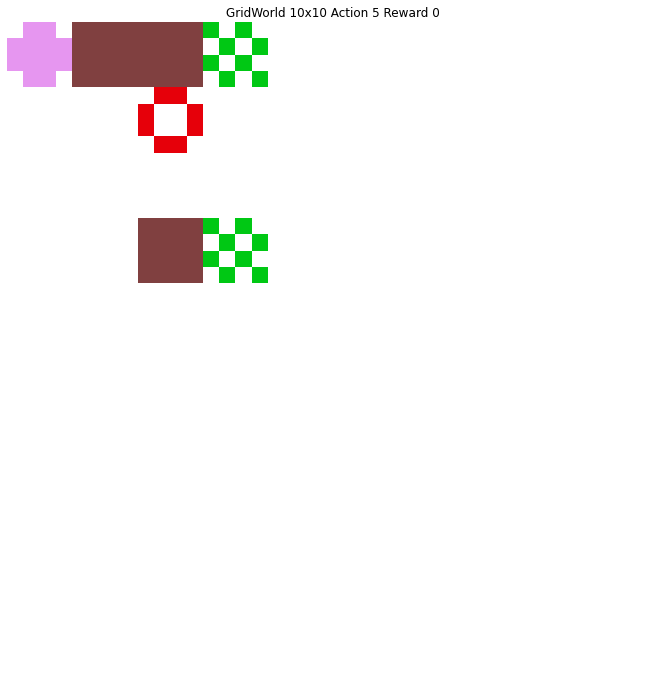

In [69]:
env.reset()
env.render()

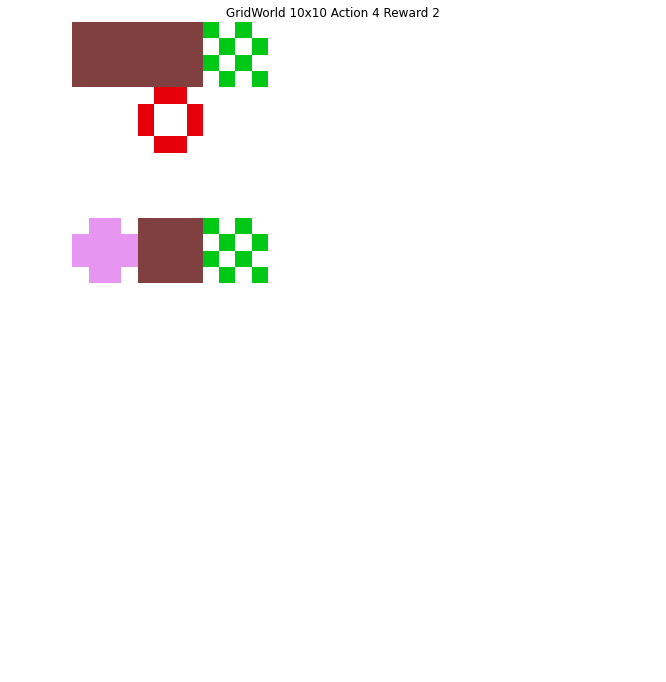

In [74]:
(obs, reward, done) = env.step(4)
env.render()

In [46]:
done

False

In [50]:
reward

## Complicar un poco el entorno
 El método de transProb en el propotipo anterior siempre regresa el mismo número [1], podría ser más interesante que algunos elementos agregaran cierta incertidumbre en los movimientos de los agentes en este entorno!


In [ ]:
class stochasticGridWorld(gridWorld):
    def transProb(self, state, action):
        # Agregar algunas modificaciones a las probabilidades 
        # de que estados podrían ser a continuación
        
        return [], []